# Electric Fields Lab

### 1) Upload a screenshot of your simulated electric field set up with electric field lines turned on. (5 pts)

![A picture of the simulated electric field...](SimulatedElectricField.png)


### 2) Submit the Github link for your plot of ln(E(r)/E0) vs. ln(r/r0) with the appropriate fit parameters.  (10 points)

See plotting code below:

#### Usual Error Library...

In [12]:
from IPython.display import Markdown
from typing import Iterable, Tuple, Union
# Define our rules...

def rule_1(c, error_val):
    return abs(c) * error_val

def rule_2(c, val, error_val, power):
    return abs(c * power * val ** (power - 1)) * error_val

def rule_3(*err_vals: Iterable[float]) -> float:
    """
    Calculate rule 3 from the paper 'Treatment of Data'.
    
    @param err_vals: A list of parameters, being the errors in each value. It is assumed they were summed 
                     together to get the final value.
    
    @returns: The error of all of the sum of the values...
    """
    total = 0
    
    for err in err_vals:
        total += err ** 2
    
    return np.sqrt(total)


def rule_4(value: float, *error_list: Iterable[Tuple[float, float, float]]) -> float:
    """
    Calculate rule 4 from the paper 'Treatment of Data'.
    
    @param value: The value of the thing we are trying to calculate the error of.
    @param error_list: A list of length 3 tuples. 
                       Each tuple should contain:
                       - A float: A value in the error formula.
                       - A float: The measured error in the above value.
                       - A float: The power of the above value in the multiplicative formula.

    @returns: A float, being the error in 'value'.
    """
    total = 0
    
    for x, x_err, power in error_list:
        total += (power * (x_err / x)) ** 2
        
    return abs(value) * np.sqrt(total)

# Fixed bug in checking code below...
FloatVec = Union[float, np.ndarray] 
BoolVec = Union[bool, np.ndarray]

def values_agree(val_1: FloatVec, err_1: FloatVec, val_2: FloatVec, err_2: FloatVec) -> BoolVec:
    """
    Determines if the values in 2 vectors(arrays) agree with each other, given there uncertainty values. 
    
    @param val_1: The 1st array of values.
    @param err_1: The uncertainty values for the 1st vector.
    @param val_2: The 2nd array of values.
    @param err_2: The uncertainty values for the 2st vector. 
    
    @returns: A vector of booleans, being whether each value agrees with the other.
    """
    # Grab the ranges for each value...
    r11, r12 = val_1 - err_1, val_1 + err_1
    r21, r22 = val_2 - err_2, val_2 + err_2
    
    # The ranges are sorted (r21 <= r22 and r11 <= r12), so the simple 2 checks below are enough. 
    # Check 1: Does r21(lowest value of 2nd range) land above the 1st range? If so fail...
    # Check 2: Does r22(highest value of 2nd range) fall below the 1st range? If so fail...
    return ((r21 <= r12) & (r11 <= r22))

#### Plotting & Calculation Code:

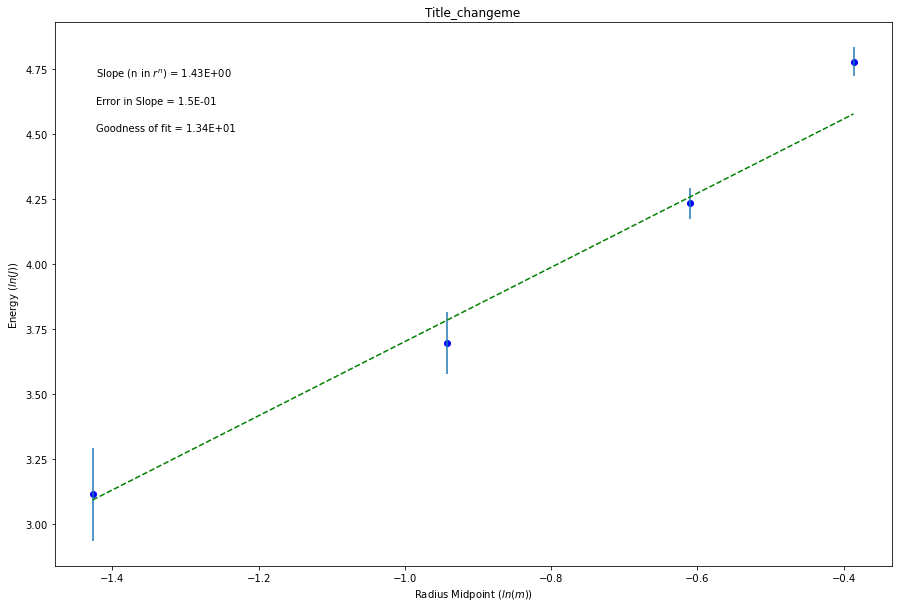

Value for $n$ in $r^n$: $1.428 \pm 0.152$

Expected Value Range for n: 1.276, 1.579

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown

data = pd.read_csv("data.csv")

# Voltage...
V = np.array(data["Voltage (V)"])
err_V = np.array(data["Voltage Error(V)"])

# Radius
r = np.array(data["Radius (cm)"]) / 100  # cm -> m
err_r = np.array(data["Radius Error(cm)"] / 100) # cm -> m

# Compute delta R and delta V...
delta_V = np.diff(V)
err_delta_V = rule_3(err_V[:-1], err_V[1:])
delta_r = np.diff(r)
err_delta_r = rule_3(err_r[:-1], err_r[1:])

# Compute the energy, -(dV / dr)...
E = (delta_V / delta_r)
err_E = rule_4(E, (delta_V, err_delta_V, 1), (delta_r, err_delta_r, -1))

# Compute mid radius, (r1 + r2) / 2:
r_mid = (r[1:] + r[:-1]) / 2
err_r_mid = rule_1(1/2, rule_3(err_r[1:], err_r[:-1])) # <-- We don't use this...

# Now compute log of the energy...
logE = np.log(E)
err_logE = np.log(E + err_E) - logE

#--------------------------------------------#
#Re-assign variables as x, y, dy so that the following code may remain generic

x = np.log(r_mid)  # Midpoint radius of each segment, meters...
y = logE  # Energy, in Joules...
dy = err_logE  # Energy, in Joules...
 
#Find the intercept and slope, b and m, from Python's polynomial fitting function
b, m=np.polynomial.polynomial.polyfit(x,y,1,w=dy)

#Write the equation for the best fit line based on the slope and intercept
fit = b+m*x

#Calculate the error in slope and intercept 
#def Delta(x, dy) is a function, and we will learn how to write our own at a later date. They are very useful!
def Delta(x, dy):
    D = (sum(1/dy**2))*(sum(x**2/dy**2))-(sum(x/dy**2))**2
    return D
 
D=Delta(x, dy)
 
dm = np.sqrt(1/D*sum(1/dy**2)) #error in slope
db = np.sqrt(1/D*sum(x**2/dy**2)) #error in intercept

#Calculate the "goodness of fit" from the linear least squares fitting document
def LLSFD2(x,y,dy):
    N = sum(((y-b-m*x)/dy)**2)
    return N
                      
N = LLSFD2(x,y,dy)

#-----------------------------------------------------------------------#
#Plot data on graph. Plot error bars and place values for slope, error in slope and goodness of fit on the plot using "annotate"
plt.figure(figsize=(15,10))
 
plt.plot(x, fit, color='green', linestyle='--')
plt.scatter(x, y, color='blue', marker='o')
 
plt.xlabel('Radius Midpoint $(ln(m))$')
plt.ylabel('Energy $(ln(J))$')
plt.title('Title_changeme')
 
plt.errorbar(x, y, yerr=dy, xerr=None, fmt="none") #don't need to plot x error bars
 
plt.annotate('Slope (n in $r^n$) = {value:.{digits}E}'.format(value=m, digits=2),
             (0.05, 0.9), xycoords='axes fraction')
 
plt.annotate('Error in Slope = {value:.{digits}E}'.format(value=dm, digits=1),
             (0.05, 0.85), xycoords='axes fraction')
 
plt.annotate('Goodness of fit = {value:.{digits}E}'.format(value=N, digits=2),
             (0.05, 0.80), xycoords='axes fraction')

plt.show()

# Display the value for n in a nice format...
display(Markdown(f"Value for $n$ in $r^n$: ${m:.03f} \pm {dm:.03f}$"))
display(Markdown(f"Expected Value Range for n: {m - dm:.03f}, {m + dm:.03f}"))

###  3) What is the value of n you found from your plot including the uncertainty?  Does your value agree with the accepted value n = 1?  Justify your answer.  (6 points)

The value I found for n was $1.428 \pm 0.152$. This value does not agree with the accepted value, and honestly isn't even close, as the value asserts the accepted value is between 1.276 and 1.579, which it is not. I see this discrepancy most likely being attributed to my inability to draw a accurate circle in the simulation software.

###  4) For the following, if we place a charge +q at point A, where can it be moved with no work involved? (point B, C and/or D)

![The image from the quiz...](QuizImage.jpeg)

It can be moved to point B, because B is on the same Gaussian surface as A, meaning the flux(energy through the surface) at that level is constant.